# 모듈 import

In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# gpu

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

# 데이터 전처리

In [3]:
def data_preprocessing(past_sales_file, store_file):
    past_sales = pd.read_csv(past_sales_file)
    store = pd.read_csv(store_file)
    
    past_sales['Date'] = pd.to_datetime(past_sales['Date'], format="%Y-%m-%d") # 년도, 달, 일 순으로 format
    # a = 공휴일, b = 부활절 공휴일, c = 크리스마스, d = 없음
    past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
    past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
    past_sales = past_sales.sort_values('Date') # date 기준으로 정렬
    past_sales = pd.get_dummies(data = past_sales,columns=['StateHoliday']) # StateHoliday를 더미 가변수로 대체, 결측값 없다는 거 확인 완료
    
    store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
    store = pd.get_dummies(data = store, columns = ['Assortment']) # 규모를 더미 가변수로 대체, storetype = a에는 규모가 b인 상점은 없음
    
    # 결측값 확인 : past_sales.isnull().sum(), store_a.isnull().sum()
    # store의 CompetitionDistance에 3개 있음
    # 결측값 : 평균으로 대체
    store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean())
    
    # 병합
    data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')
    data = pd.get_dummies(data = data, columns = ['DayOfWeek']) # 요일 더미의 가변수로 추가
    data['Month']=pd.DatetimeIndex(data.Date).month
    data['Day']=pd.DatetimeIndex(data.Date).day
    data = data.drop(['Date'],axis=1) 
    data = data[data['StoreType'] == 'a']
    data = data.drop(['StoreType'], axis=1)

    pd.options.display.max_columns = None

    
    return data

# Standardization

In [4]:
def data_normalization(past_sales_file, store_file):
    data = data_preprocessing(past_sales_file, store_file)
    
    scaler = StandardScaler().fit(data)
    data = pd.DataFrame(scaler.transform(data),index = data.index, columns = data.columns)
    
    return data

In [5]:
data = data_normalization('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv', 'C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# windows_size

In [6]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
# features = features.values
# target = target.values

features_copy = []
target_copy = []

windows_size = 30
for i in range(len(features)-windows_size) :
    features_copy.append(np.array(features.iloc[i:i+windows_size]))
    target_copy.append(np.array(target.iloc[i:i+windows_size]))

In [7]:
print(len(target_copy))

551597


# train_test_split

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(features_copy, target_copy, test_size=0.2,random_state=1)

In [9]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

# 학습

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32,input_shape=(30,23),return_sequences=True))
model.add(tf.keras.layers.LSTM(32,return_sequences=True))
model.add(tf.keras.layers.LSTM(16,return_sequences=False))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            7168      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 18,913
Trainable params: 18,913
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='mse',
             optimizer='adam',
             metrics=['mae'])

In [ ]:
history = model.fit(x_train,y_train,
                   validation_data = (x_valid,y_valid),
                   batch_size = 5,
                   epochs = 10)

Epoch 1/10
88256/88256 [==============================] - 2252s 26ms/step - loss: 0.7113 - mae: 0.6069 - val_loss: 0.6969 - val_mae: 0.5984
Epoch 2/10
88256/88256 [==============================] - 2161s 24ms/step - loss: 0.6963 - mae: 0.5962 - val_loss: 0.6913 - val_mae: 0.5947
Epoch 3/10
64394/88256 [====================>.........] - ETA: 9:20 - loss: 0.6929 - mae: 0.5939

In [ ]:
pred = model.predict(x_valid)
y_train1 = target[0:len(x_train)]
y_test1 = target[len(x_train):len(x_train)+len(x_test)]
y_valid1 = target[len(x_train)+len(x_test):len(target)-windows_size]

In [ ]:
y_valid1 = y_valid1.values.tolist()
y_valid1 = np.array(y_valid1)
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_valid1, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

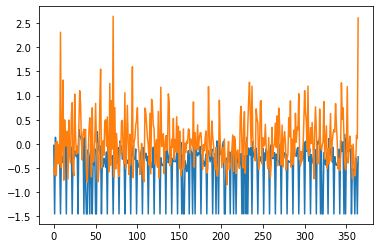

In [29]:
pred_365 = pred[0:365]
y_valid1_365 = y_valid1[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_valid1_365, label='True')
ax.plot(pred_365, label='Prediction')

In [31]:
from sklearn.metrics import r2_score
r2 = r2_score(y_valid1, pred)
print(r2)

-0.3162549320875274
